In [10]:
import copy
import numpy as np
import aplpy
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
# from six.moves import cPickle as pickle
import pickle
import time

# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()

## Porting stochastic seeing and sky-brightness from Lenspop

As an example, we define the camera and observational settings of a LSST-like observation. We define one camera setting and three different observations corresponding th g,r,i imaging. First, we load stochastic seeing and sky brightness from LensPop. Then, we define all static parameters. We then construct an object that reads from the list of stochastic seeing and skybrightness from lenspop and randomly samples from the list.

In [18]:
directory = "2dpdfs"
twodg = pickle.load(open("%s/2dg_LSST.pkl" %directory,'rb'))
twodr = pickle.load(open("%s/2dr_LSST.pkl" %directory,'rb'))
twodi = pickle.load(open("%s/2di_LSST.pkl" %directory,'rb'))
# twodg[:,0]) seeing
# twodg[:,1]) sky brightness

# Use these if you are using Python 3 or have issues with pickle reading the file
# twodg = pickle.load(open("%s/2dg_LSST.pkl" %directory,'rb'),encoding='latin1')
# twodr = pickle.load(open("%s/2dr_LSST.pkl" %directory,'rb'),encoding='latin1')
# twodi = pickle.load(open("%s/2di_LSST.pkl" %directory,'rb'),encoding='latin1')

# Camera setting
LSST_camera = {'read_noise': 10,
               'pixel_scale': 0.263, 
               'ccd_gain': 4.5  
              }

# Static noise quantities
LSST_g_band_obs = {'exposure_time': 90.,
                   'magnitude_zero_point': 30, 
                   'num_exposures': 10, 
                   'psf_type': 'GAUSSIAN', 
                  }

LSST_r_band_obs = {'exposure_time': 90.,
                   'magnitude_zero_point': 30,
                   'num_exposures': 10,
                   'psf_type': 'GAUSSIAN'}

LSST_i_band_obs = {'exposure_time': 90.,
                   'magnitude_zero_point': 30,
                   'num_exposures': 10,
                   'psf_type': 'GAUSSIAN'}


class StochasticNoise(object):
  "Returns an array of specified size of randomly selected values of stochastic seeing and sky-brightness from a list."
  def __init__(self, size, pdf):
    rand_idx = np.random.randint(len(pdf),size=size)
    self.seeing = pdf[rand_idx,0]
    self.sky_brightness = pdf[rand_idx,1]

n = 10
LSST_g_stochastic_noise = StochasticNoise(n,twodg)
LSST_r_stochastic_noise = StochasticNoise(n,twodr)
LSST_i_stochastic_noise = StochasticNoise(n,twodi)

## Define model settings

The model settings are handled by the SimulationAPI.model_api ModelAPI class. The role is to return instances of the lenstronomy LightModel, LensModel, PointSource modules according to the options chosen by the user. Currently, all other model choices are equivalent to the ones provided by LightModel, LensModel, PointSource. The current options of the class instance only describe a subset of possibilities and we refer to the specific class instances for details about all the possibilities.

For this example, we chose a single lens plane and a single source plane, elliptical Sersic profiles and an additional lensed point source.

In [43]:
kwargs_model = {'lens_model_list': ['SIE'],  # list of lens models to be used
                'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                'source_light_model_list': ['SERSIC_ELLIPSE'],  # list of extended source models to be used
                # 'point_source_model_list': ['SOURCE_POSITION']  # list of point source models to be used
    }

## Simulates lens + source light and lens mass model for one lens

In [58]:
# g-band

# lens light
kwargs_lens_light_mag_g = [{'magnitude': 20, 'R_sersic': .6, 'n_sersic': 4, 'e1': 0.1, 'e2': -0.1, 'center_x': 0, 'center_y': 0}]
# source light
kwargs_source_mag_g = [{'magnitude': 23, 'R_sersic': 0.3, 'n_sersic': 1, 'e1': -0.3, 'e2': -0.2, 'center_x': 0.2, 'center_y': 0.01}]
# point source
kwargs_ps_mag_g = [{'magnitude': 40, 'ra_source': 0.03, 'dec_source': 0}]


# and now we define the colors of the other two bands
# r-band
g_r_source = 1  # color mag_g - mag_r for source
g_r_lens = -1  # color mag_g - mag_r for lens light
g_r_ps = 0
kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
kwargs_lens_light_mag_r[0]['magnitude'] -= g_r_lens

kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]['magnitude'] -= g_r_source

kwargs_ps_mag_r = copy.deepcopy(kwargs_ps_mag_g)
kwargs_ps_mag_r[0]['magnitude'] -= g_r_source


# i-band
g_i_source = 2
g_i_lens = -2
g_i_ps = 0
kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
kwargs_lens_light_mag_i[0]['magnitude'] -= g_i_lens

kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_i[0]['magnitude'] -= g_i_source

kwargs_ps_mag_i = copy.deepcopy(kwargs_ps_mag_g)
kwargs_ps_mag_i[0]['magnitude'] -= g_i_source

#----

kwargs_lens = [
    {'theta_E': 1, 'e1': 0.1, 'e2': -0.1, 'center_x': 0, 'center_y': 0},  # SIE model
    # {'e1': 0.03, 'e2': 0.01}  # SHEAR model
]

## Simulate 100 different sets of stochastic seeing and sky-brightness.

10 images took 0.300738096237 seconds to generate


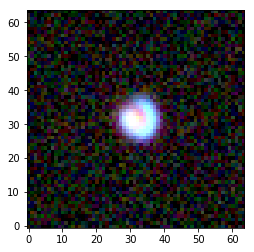

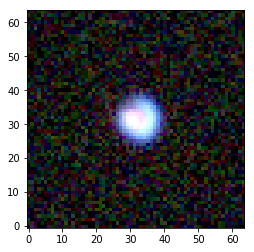

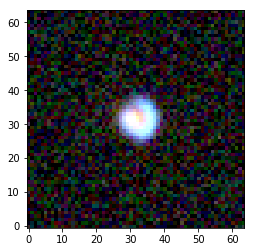

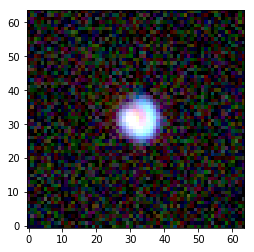

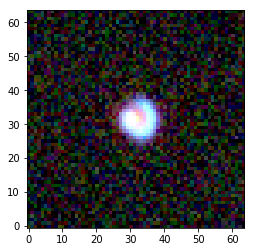

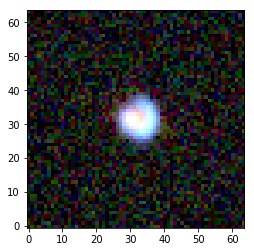

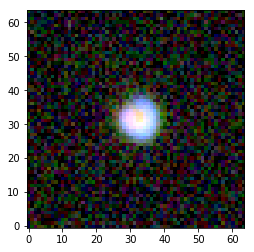

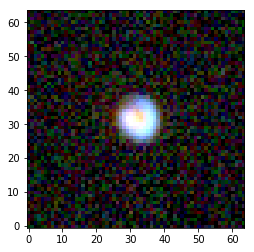

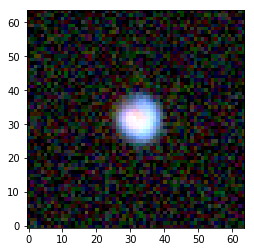

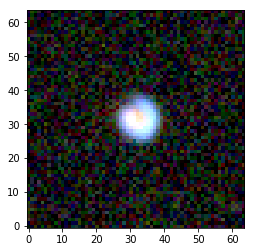

In [60]:
start_time = time.time()
for i in range(n):
    LSST_g_band_stochastic = {'seeing': LSST_g_stochastic_noise.seeing[i],
                              'sky_brightness': LSST_g_stochastic_noise.sky_brightness[i]}
    LSST_r_band_stochastic = {'seeing': LSST_r_stochastic_noise.seeing[i],
                              'sky_brightness': LSST_r_stochastic_noise.sky_brightness[i]}
    LSST_i_band_stochastic = {'seeing': LSST_i_stochastic_noise.seeing[i],
                              'sky_brightness': LSST_i_stochastic_noise.sky_brightness[i]}

    kwargs_g_band1 = util.merge_dicts(LSST_camera, LSST_g_band_obs)
    kwargs_g_band = util.merge_dicts(kwargs_g_band1, LSST_g_band_stochastic)
    kwargs_r_band1 = util.merge_dicts(LSST_camera, LSST_r_band_obs)
    kwargs_r_band = util.merge_dicts(kwargs_r_band1, LSST_r_band_stochastic)
    kwargs_i_band1 = util.merge_dicts(LSST_camera, LSST_i_band_obs)
    kwargs_i_band = util.merge_dicts(kwargs_i_band1, LSST_i_band_stochastic)


    numpix = 64  # number of pixels per axis of the image to be modelled

    # here we define the numerical options used in the ImSim module. 
    # Have a look at the ImageNumerics class for detailed descriptions.
    # If not further specified, the default settings are used.
    kwargs_numerics = {'point_source_subgrid': 1}

    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model, kwargs_numerics=kwargs_numerics)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model, kwargs_numerics=kwargs_numerics)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model, kwargs_numerics=kwargs_numerics)

    # turn magnitude kwargs into lenstronomy kwargs
    kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)
    kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_r.magnitude2amplitude(kwargs_lens_light_mag_r, kwargs_source_mag_r, kwargs_ps_mag_r)
    kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_i.magnitude2amplitude(kwargs_lens_light_mag_i, kwargs_source_mag_i, kwargs_ps_mag_i)

    # return the ImSim instance. With this class instance, you can compute all the
    # modelling accessible of the core modules. See class documentation and other notebooks.
    imSim_g = sim_g.image_model_class
    imSim_r = sim_r.image_model_class
    imSim_i = sim_i.image_model_class

    #----

    image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g, kwargs_ps_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i, kwargs_ps_i)

    # add noise
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_g.noise_for_model(model=image_r)
    image_i += sim_g.noise_for_model(model=image_i)

    # and plot it
    img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)
    img[:,:,0] = plot_util.sqrt(image_g, scale_min=0, scale_max=100)
    img[:,:,1] = plot_util.sqrt(image_r, scale_min=0, scale_max=100)
    img[:,:,2] = plot_util.sqrt(image_i, scale_min=0, scale_max=100)
    
    plt.figure()
    plt.imshow(img, aspect='equal', origin='lower')
    plt.clf

end_time = time.time()
print("%s images took %s seconds to generate" %(n, end_time-start_time))